# Modelo de classificação - Campanha de marketing de uma instituição bancária

Os dados referem-se a campanhas de marketing de uma instituição bancária portuguesa realizadas entre 2008 e 2010. O objetivo é prever se o cliente fará um depósito a prazo.

Visando facilitar a análise dos dados, desenvolvi um dashboard que pode ser acessado em [Dashboard de Marketing](https://app.powerbi.com/view?r=eyJrIjoiYjJlMjQxYWQtMTZlYy00ZDYzLWFhYWMtOTM4ZTQ4YTg1NTFlIiwidCI6ImUxYWFhM2NmLTI5MjItNDEyYy04MDE1LWRlZTEyZDg1MTJmYSJ9&pageName=ReportSectionac001f34a9fc80bde708).

O conjunto de dados pode ser obtido em: <https://archive.ics.uci.edu/ml/datasets/Bank+Marketing>.

**Fonte**

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

## Resumo
* Importação das principais bibliotecas e carregamento dos dados
* Dicionários dos parâmetros e constantes utilizados no modelo
* Análise inicial
 * Relação entre as variáveis independentes numéricas
* Feature Engineering
 * Adicionando os anos
 * Adicionando os blocos
* Divisão entre treino e teste
* Pré-processamento dos dados
* Embeddings supervisionados
* Técnica de validação prequential expanding
* Otimização Bayesiana - LightGBM
* Resultados no conjunto de teste


## Importação das principais bibliotecas e carregamento dos dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_theme(style = 'darkgrid')
from collections import Counter

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [3]:
dataset = pd.read_csv('bank-additional-full.csv', delimiter=';')

## Dicionários dos parâmetros e constantes utilizados no modelo

In [41]:
params = {
    'num_epochs': 500,                                            # numero de epochs de treinamento do embedding
    'seed': 0,                                                    # semente aleatoria. Definida para tornar os resultados reproduziveis
    'verbose': True,                                              # opcao para visualizar os detalhes do treinamento
    'n_calls_tuning': 20,                                         # numero de chamadas do otimizador bayesiano
    'mdl_params':                                                 # paramentros de otimizacao do modelo
        [(2, 200),                                                # quantidade minima de registros nas folhas
         (10, 1000),                                              # numero de folhas
         (1e-3, 1e-2, 'log-uniform'),                             # taxa de aprendizado
         (0.1, 0.9),                                              # proporcao de colunas utilizadas por amostra
         (100, 1000)]                                             # numero de arvores
}   

constants = {
    'DT_TRAIN': 0,                                                # dataset para treino e validacao (sera definido apos limpeza dos dados)
    'LEN_SPLIT_TRAIN_TEST': 0.7,                                  # split de divisao entre treino e teste
    'NUM_BLOCKS_VALIDATION': 10,                                  # numero de divisoes para treino e validacao
    'CATEGORICAL_COLUMNS':  [                                     # colunas com dados categoricos
        'job', 
        'marital', 
        'education', 
        'default', 
        'housing', 
        'loan', 
        'contact', 
        'month', 
        'day_of_week', 
        'poutcome'
    ]    
}


## Análise Inicial

In [5]:
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
dataset['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

Variável dependente desbalanceada. Necessário tratamento para correção.

### Relação entre as variáveis independentes numéricas

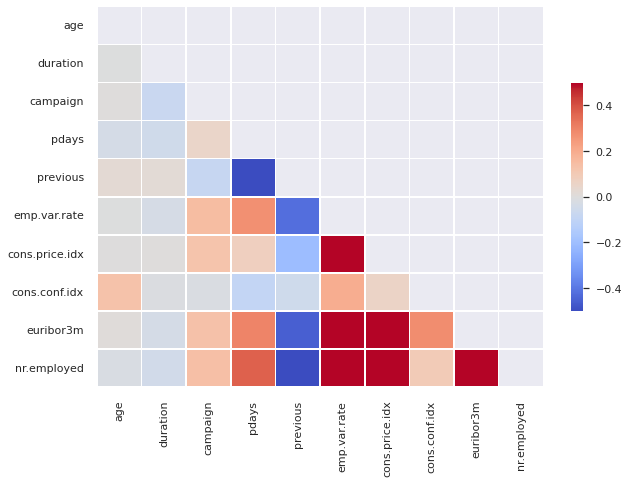

In [8]:
dt_corr = dataset.corr()
dt_mask = np.zeros_like(dt_corr, dtype=np.bool)
dt_mask[np.triu_indices_from(dt_mask)] = True
fig, ax = plt.subplots(figsize=(10, 7))
pl = sns.heatmap(dt_corr, mask=dt_mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
plt.show()

Alta relação positiva entre as variáveis econômicas e sociais (emp.var.rate, cons.price.idx, cons.conf.idx e euribor3m)


## Feature Engineering

### Adicionando os anos

In [9]:
months = dataset['month']

# ano inicial dos dados
year = 2008 
list_year = []
last_month = months[0]

for current_month in months:
  if last_month != current_month:
    # se o mes anterior e dezembro, adiociona 1 a variavel ano
    if last_month == 'dec': 
      year += 1
    last_month = current_month
    
  list_year.append(year)

In [10]:
dataset.insert(20, "year", list_year)

### Adicionando blocos

In [11]:
# criacao da coluna que servira para segmentar os dados em treino, validacao e teste
# sera utilizada a tecnica prequential expanding
dataset.insert(21, "block", 10)

In [12]:
SPLIT_BLOCK = 1 / constants['NUM_BLOCKS_VALIDATION'] 
SIZE_XTRAIN = int(dataset.shape[0] * constants['LEN_SPLIT_TRAIN_TEST'])

for block in range(constants['NUM_BLOCKS_VALIDATION']):
  # preenchimento da coluna block com amostras de tamanhos equivalentes, com excecao do ultimo que sera para teste
  dataset.iloc[int(SIZE_XTRAIN * block * SPLIT_BLOCK): int(SIZE_XTRAIN * SPLIT_BLOCK * (block + 1)), -2] = block

In [13]:
dataset['block'].value_counts().sort_index()

0      2883
1      2883
2      2883
3      2883
4      2883
5      2883
6      2883
7      2883
8      2883
9      2884
10    12357
Name: block, dtype: int64

In [14]:
dataset.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
year              0
block             0
y                 0
dtype: int64

Não há dados nulos

## Divisão entre treino e teste

In [15]:
dt_train = dataset[dataset.block != 10]
dt_test = dataset[dataset.block == 10]

In [42]:
constants['DT_TRAIN'] = dt_train

## Pré-processamento dos dados

In [17]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 373 kB/s 


In [18]:
from category_encoders import CountEncoder
from sklearn.preprocessing import LabelEncoder

# classe com metodos estaticos para pre-processamento dos dados
class DataProcessingUtils:

  # aplica uma transformacao nas variaveis categoricas de acordo com a contagem de cada categoria
  @staticmethod
  def count_encoder(train, test):
    train2 = train.copy()
    test2 = test.copy()

    for clm in constants['CATEGORICAL_COLUMNS']:
      cenc = CountEncoder(normalize=False)

      train2['COUNT_{}'.format(clm)] = cenc.fit_transform(train2[clm]) 
      train2.drop(clm, axis=1, inplace=True)

      test2['COUNT_{}'.format(clm)] = cenc.transform(test2[clm]) 
      test2.drop(clm, axis=1, inplace=True)

    return train2, test2

  # remove as colunas especificadas do conjunto informado
  @staticmethod
  def drop_columns(dataset, dp_col):
    clm = list(dataset.columns)

    for c in dp_col:
      if c in clm: 
        clm.remove(c)

    return dataset.filter(items=clm)

  # retorna um dicionario com os valores maximos das contagens de cada coluna categorica
  @staticmethod
  def create_dic_ctg(dataset):
    dic_max_ctg = {
      'DIST_VALUES_JOB': max(dataset.COUNT_job) + 1,
      'DIST_VALUES_MARITAL': max(dataset.COUNT_marital) + 1,
      'DIST_VALUES_EDUCATION': max(dataset.COUNT_education) + 1,
      'DIST_VALUES_DEFAULT': max(dataset.COUNT_default) + 1,
      'DIST_VALUES_HOUSING': max(dataset.COUNT_housing) + 1,
      'DIST_VALUES_LOAN': max(dataset.COUNT_loan) + 1,
      'DIST_VALUES_CONTACT': max(dataset.COUNT_contact) + 1,
      'DIST_VALUES_MONTH': max(dataset.COUNT_month) + 1,
      'DIST_VALUES_DAYOFWEEK': max(dataset.COUNT_day_of_week) + 1,
      'DIST_VALUES_POUTCOME': max(dataset.COUNT_poutcome) + 1
    }
    return dic_max_ctg

  # concatena um dataframe pandas com um array numpy
  @staticmethod
  def concat_df(X_df, X_np):
    X_emb = X_np.tolist()
    X_emb_df = pd.DataFrame(X_emb)
    X_emb_df.reset_index(drop=True, inplace=True)

    X_wth_ctg = X_df.iloc[:, :-10]
    X_wth_ctg.reset_index(drop=True, inplace=True)
    
    return pd.concat([X_wth_ctg, X_emb_df], axis=1, ignore_index=False)

  # converte arrays numpy em tensores
  @staticmethod
  def create_tensor(dt, is_target=False):
    if is_target:
      tensor = torch.from_numpy(dt.values.reshape(-1,1))
      tensor = tensor.type(torch.FloatTensor)
    
    else:
      tensor = torch.from_numpy(dt.filter(regex=r'COUNT').values)
      tensor = tensor.long()

    return tensor

  # aplica a divisao do dataset informado em conjuntos de treino e validacao
  @staticmethod
  def train_val_split(dataset, block, dp_columns):
    train = dataset[dataset['block'] < block]
    val = dataset[dataset['block'] == block]

    train, val = DataProcessingUtils.count_encoder(train, val)

    le = LabelEncoder()
    train['y'] = le.fit_transform(train['y'])
    val['y'] = le.transform(val['y'])

    X_train = DataProcessingUtils.drop_columns(train, dp_columns)
    X_val = DataProcessingUtils.drop_columns(val, dp_columns)

    y_train = train['y']
    y_val = val['y']

    return X_train, X_val, y_train, y_val

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Embeddings supervisionados

In [19]:
import torch.nn as nn
import torch
import torch.optim as opt
import torch.nn.functional as F

In [20]:
# tamanho de cada array das variaveis categoricas
EMBEDDING_DIM = 5 

# classe para criacao da estrutura do embedding
class EmbeddingNet(nn.Module):
  def __init__(self, dic_max_ctg):
    super(EmbeddingNet, self).__init__()

    # inicializacao dos valores maximos da contagem de cada coluna categorica
    self.e_job = nn.Embedding(dic_max_ctg['DIST_VALUES_JOB'], EMBEDDING_DIM, padding_idx=0)
    self.e_marital = nn.Embedding(dic_max_ctg['DIST_VALUES_MARITAL'], EMBEDDING_DIM, padding_idx=0)
    self.e_education = nn.Embedding(dic_max_ctg['DIST_VALUES_EDUCATION'], EMBEDDING_DIM, padding_idx=0)
    self.e_default = nn.Embedding(dic_max_ctg['DIST_VALUES_DEFAULT'], EMBEDDING_DIM, padding_idx=0)
    self.e_housing = nn.Embedding(dic_max_ctg['DIST_VALUES_HOUSING'], EMBEDDING_DIM, padding_idx=0)
    self.e_loan = nn.Embedding(dic_max_ctg['DIST_VALUES_LOAN'], EMBEDDING_DIM, padding_idx=0)
    self.e_contact = nn.Embedding(dic_max_ctg['DIST_VALUES_CONTACT'], EMBEDDING_DIM, padding_idx=0)
    self.e_month = nn.Embedding(dic_max_ctg['DIST_VALUES_MONTH'], EMBEDDING_DIM, padding_idx=0)
    self.e_day_of_week = nn.Embedding(dic_max_ctg['DIST_VALUES_DAYOFWEEK'], EMBEDDING_DIM, padding_idx=0)
    self.e_poutcome = nn.Embedding(dic_max_ctg['DIST_VALUES_POUTCOME'], EMBEDDING_DIM, padding_idx=0)

    # definicao da estrutura da rede. Tera tres camadas ocultas
    self.hid1 = nn.Linear(50, 100)
    self.hid2 = nn.Linear(100, 100)
    self.hid3 = nn.Linear(100, 100)
    self.out = nn.Linear(100, 1)

  def forward(self, x, return_embeddings=False, return_hid3=False):
    # retorno das representacoes criadas
    e_job = self.e_job(x[:,0])
    e_marital = self.e_marital(x[:,1])
    e_education = self.e_education(x[:,2])
    e_default = self.e_default(x[:,3])
    e_housing = self.e_housing(x[:,4])
    e_loan = self.e_loan(x[:,5])
    e_contact = self.e_contact(x[:,6])
    e_month = self.e_month(x[:,7])
    e_day_of_week = self.e_day_of_week(x[:,8])
    e_poutcome = self.e_poutcome(x[:,9])

    # concatenacao das representacoes
    e = torch.cat([e_job, e_marital, e_education, e_default, e_housing, e_loan, e_contact, e_month, e_day_of_week, e_poutcome], dim=-1)
    x = F.relu(self.hid1(e))
    x = F.relu(self.hid2(x))
    
    hid3 = self.hid3(x)
    x = F.relu(hid3)
    x = self.out(x)
    
    if return_embeddings:
        return e
    elif return_hid3:
        return hid3
    return x

In [21]:
from sklearn.metrics import median_absolute_error

class Embedding:

  def __init__(self, X_dt, y_dt, num_epochs=1000):
    self.X_dt = X_dt
    self.y_dt = y_dt
    self.num_epochs = num_epochs

    dic_max_ctg = DataProcessingUtils.create_dic_ctg(self.X_dt)

    self.net = EmbeddingNet(dic_max_ctg)


  def training(self, seed=0):
    if params['verbose']:
      print('\n*************************** Training Embedding ****************************')
    
    torch.manual_seed(seed)

    criterion = nn.MSELoss()
    optimizer = opt.Adam(self.net.parameters(), lr=1e-4)

    x = DataProcessingUtils.create_tensor(self.X_dt)
    y = DataProcessingUtils.create_tensor(self.y_dt, is_target=True)

    for e in range(self.num_epochs):
      optimizer.zero_grad() 
      p = self.net(x)
      loss = criterion(p, y)
      
      loss.backward()
      optimizer.step()
      
      p_numpy = p.cpu().detach().numpy()

      if params['verbose'] and (e + 1) % (self.num_epochs / 10) == 0:
        print("\tEPOCH {}: {}".format(e + 1, median_absolute_error(y, p_numpy)))

    if params['verbose']:
      print('*************************** Training Embedding ****************************\n')

  def save(self, path):
    torch.save(self.net.state_dict(), path) 

  def get_net(self):
    return self.net
                

## Técnica de validação prequential expanding

In [22]:
from scipy.stats import spearmanr

# metodo de implementacao da tecnica de validacao prequential expanding.
# Os dados de treino e validacao foram divididos em 10 blocos. Em cada interacao,
# N blocos sao utilizados para treino e o ultimo para validacao, onde N incrementa em 1 apos cada ciclo
def pe_validation(mdl):
  if params['verbose']:
    print('\n********************** Prequential Expanding Validation ************************')

  results_val = []
  dp_columns = ['block', 'y']

  for block in range(1, constants['NUM_BLOCKS_VALIDATION']):
    if params['verbose']: 
      print("Train blocks 0-{} - Validation Block {}".format(block - 1, block))

    X_train, X_val, y_train, y_val = DataProcessingUtils.train_val_split(constants['DT_TRAIN'], block, dp_columns)

    emb = Embedding(X_train, y_train, num_epochs=params['num_epochs'])
    emb.training()
    net = emb.get_net()

    X_train_tensor = DataProcessingUtils.create_tensor(X_train)
    X_train_emb = net(X_train_tensor,return_embeddings=True).detach().cpu().numpy()
    X_train = DataProcessingUtils.concat_df(X_train, X_train_emb)

    X_val_tensor = DataProcessingUtils.create_tensor(X_val)
    X_val_emb = net(X_val_tensor,return_embeddings=True).detach().cpu().numpy()
    X_val = DataProcessingUtils.concat_df(X_val, X_val_emb)

    mdl.fit(X_train, y_train)
    p = mdl.predict(X_val)
    correlation = spearmanr(y_val, p).correlation
    
    results_val.append(correlation)
    
    if params['verbose']: 
      print("Correlation block {}: {}\n".format(block, correlation))
      
  if params['verbose']:
    print('********************** Prequential Expanding Validation ************************\n')
  return np.median(results_val)
    

## Otimização Bayesiana - LightGBM

In [23]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.5 MB/s 


In [24]:
from lightgbm import LGBMClassifier

# metodo de otimizacao bayesiano
def tune_lgbm(params):
    min_data_in_leaf, num_leaves, learning_rate, colsample_bytree, n_estimators = params

    mdl = LGBMClassifier(min_data_in_leaf=min_data_in_leaf,
                        num_leaves=num_leaves, 
                        learning_rate=learning_rate, 
                        n_estimators=n_estimators, 
                        colsample_bytree=colsample_bytree, 
                        class_weight='balanced', 
                        random_state=0)
    correlation = pe_validation(mdl)

    print("\nModel Result:\n\tParams: {}\n\tCorrelation: {}\n".format(str(params), str(correlation)))
    
    return -correlation

In [ ]:
from skopt import gp_minimize
res_mdl = gp_minimize(tune_lgbm, params['mdl_params'], random_state=params['seed'], verbose=params['verbose'], n_calls=params['n_calls_tuning'])

In [46]:
print("Best params: {}".format(res_mdl.x))

Best params: [148, 76, 0.01, 0.5452274810180205, 1000]


In [38]:
min_data_in_leaf, num_leaves, learning_rate, colsample_bytree, n_estimators = res_mdl.x 

mdl = LGBMClassifier(min_data_in_leaf=min_data_in_leaf,
                    num_leaves=num_leaves, 
                    learning_rate=learning_rate, 
                    n_estimators=n_estimators, 
                    colsample_bytree=colsample_bytree, 
                    class_weight='balanced', 
                    random_state=0)


## Resultados no conjunto de teste

In [44]:
dp_columns = ['block', 'y']

train, test = DataProcessingUtils.count_encoder(dt_train, dt_test)

le = LabelEncoder()
train['y'] = le.fit_transform(train['y'])
test['y'] = le.transform(test['y'])

X_train = DataProcessingUtils.drop_columns(train, dp_columns)
X_test = DataProcessingUtils.drop_columns(test, dp_columns)

y_train = train['y']
y_test = test['y']

emb = Embedding(X_train, y_train, num_epochs=params['num_epochs'])  
net = emb.get_net()
emb.training()

X_train_tensor = DataProcessingUtils.create_tensor(X_train)
X_train_emb = net(X_train_tensor,return_embeddings=True).detach().cpu().numpy()
X_train = DataProcessingUtils.concat_df(X_train, X_train_emb)

X_test_tensor = DataProcessingUtils.create_tensor(X_test)
X_test_emb = net(X_test_tensor,return_embeddings=True).detach().cpu().numpy()
X_test = DataProcessingUtils.concat_df(X_test, X_test_emb)


*************************** Training Embedding ****************************
	EPOCH 50: 0.0541604608297348
	EPOCH 100: 0.054162271320819855
	EPOCH 150: 0.05187176913022995
	EPOCH 200: 0.049293190240859985
	EPOCH 250: 0.04916322976350784
	EPOCH 300: 0.04860936850309372
	EPOCH 350: 0.048137418925762177
	EPOCH 400: 0.04702456295490265
	EPOCH 450: 0.04571803659200668
	EPOCH 500: 0.04571089521050453
*************************** Training Embedding ****************************



In [45]:
mdl.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.9, importance_type='split',
               learning_rate=0.01, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=200, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=10, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
from sklearn.metrics import classification_report

predictions = mdl.predict(X_test)
metric = spearmanr(y_test,predictions).correlation
print("Best Model\n\tParams: {}\n\tCorrelation: {}\n".format(res_mdl.x, metric)) 
print(classification_report(y_test, predictions))